In [1]:
!pip install -q scikit-learn pandas numpy matplotlib seaborn



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')


In [3]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [6]:
from google.colab import files
uploaded = files.upload()

# Load the data
df = pd.read_csv('acc_16.csv')  # Adjust filename if needed

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst few rows:")
df.head()


Saving acc_16.csv to acc_16 (2).csv
Dataset loaded: 46511 rows, 51 columns

First few rows:


,CASENUM,PSU,PJ,STRATUM,VE_TOTAL,VE_FORMS,PVH_INVL,PEDS,PERMVIT,PERNOTMVIT,...,LGTCON_IM,WEATHR_IM,MAXSEV_IM,NO_INJ_IM,ALCHL_IM,URBANICITY,REGION,PSUSTRAT,PSU_VAR,WEIGHT
0,201600014311,44,388,9,2,2,0,0,2,0,...,1,1,0,0,2,2,4,25,44,219.795475
1,201600014315,44,388,8,2,2,0,0,4,0,...,3,1,1,4,2,2,4,25,44,186.634758
2,201600014316,44,388,5,1,1,0,0,1,0,...,3,1,3,1,2,2,4,25,44,32.222550
3,201600014335,44,388,10,2,2,0,0,2,0,...,3,3,0,0,2,2,4,25,44,317.681532
4,201600014586,24,170,2,1,1,0,1,1,1,...,1,1,2,1,2,2,4,24,24,37.251626


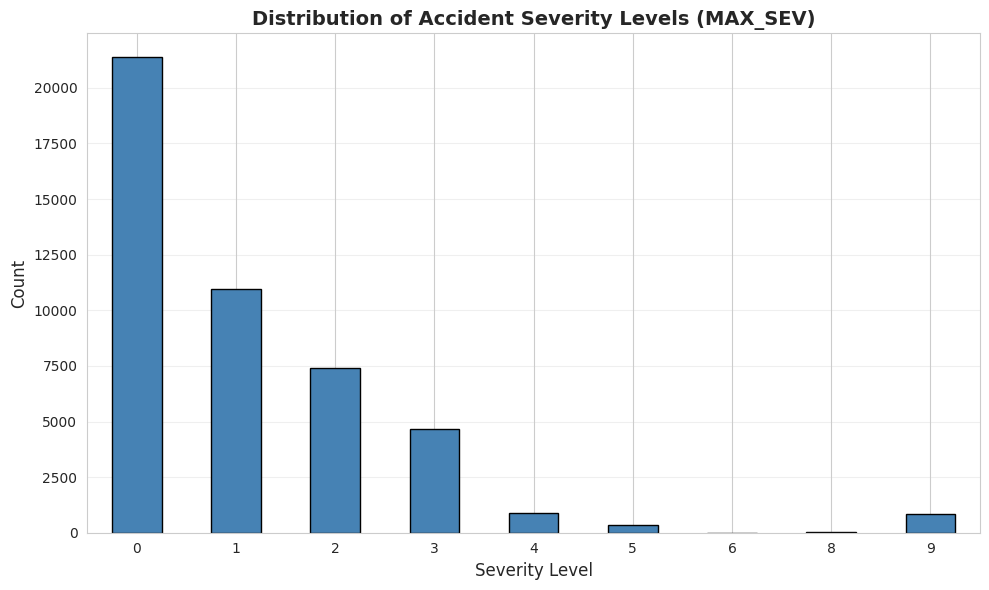

In [7]:
plt.figure(figsize=(10, 6))
df['MAX_SEV'].value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribution of Accident Severity Levels (MAX_SEV)', fontsize=14, fontweight='bold')
plt.xlabel('Severity Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
print(f"\nMissing MAX_SEV values: {df['MAX_SEV'].isna().sum()}")



Missing MAX_SEV values: 0


In [9]:
features_to_use = [
    # Temporal factors
    'MONTH', 'DAY_WEEK', 'HOUR', 'MINUTE',

    # Crash characteristics
    'VE_TOTAL',      # Number of vehicles
    'PVH_INVL',      # Number of parked/working vehicles
    'PEDS',          # Number of pedestrians
    'PERMVIT',       # Persons in motor vehicles
    'PERNOTMVIT',    # Persons not in motor vehicles

    # Crash details
    'HARM_EV',       # First harmful event
    'MAN_COLL',      # Manner of collision
    'CF1', 'CF2', 'CF3',  # Related factors

    # Location/Road conditions
    'RELJCT1', 'RELJCT2',  # Junction relation
    'TYP_INT',       # Type of intersection
    'REL_ROAD',      # Relation to roadway
    'INT_HWY',       # Interstate highway
    'WRK_ZONE',      # Work zone

    # Environmental conditions
    'LGT_COND',      # Light condition
    'WEATHER', 'WEATHER1', 'WEATHER2',

    # Special circumstances
    'SCH_BUS',       # School bus related
    'ALCOHOL',       # Alcohol involvement

    # Geographic
    'URBANICITY',    # Urban vs rural
    'REGION'         # Geographic region
]


In [10]:
df_work = df[features_to_use + ['MAX_SEV']].copy()

print(f"Selected {len(features_to_use)} features")
print(f"Working dataframe shape: {df_work.shape}")
print(f"\nFeatures being used:\n{features_to_use}")


Selected 28 features
Working dataframe shape: (46511, 29)

Features being used:
['MONTH', 'DAY_WEEK', 'HOUR', 'MINUTE', 'VE_TOTAL', 'PVH_INVL', 'PEDS', 'PERMVIT', 'PERNOTMVIT', 'HARM_EV', 'MAN_COLL', 'CF1', 'CF2', 'CF3', 'RELJCT1', 'RELJCT2', 'TYP_INT', 'REL_ROAD', 'INT_HWY', 'WRK_ZONE', 'LGT_COND', 'WEATHER', 'WEATHER1', 'WEATHER2', 'SCH_BUS', 'ALCOHOL', 'URBANICITY', 'REGION']


In [11]:
print("Missing values per column:")
missing = df_work.isnull().sum()
missing_pct = (missing / len(df_work)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Missing_Count', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])

# Basic statistics
print("\n" + "="*60)
print("BASIC STATISTICS")
print("="*60)
print(f"Total crashes: {len(df_work):,}")
print(f"Features: {len(features_to_use)}")
print(f"\nSeverity distribution:")
print(df_work['MAX_SEV'].value_counts().sort_index())


Missing values per column:
Empty DataFrame
Columns: [Missing_Count, Percentage]
Index: []

BASIC STATISTICS
Total crashes: 46,511
Features: 28

Severity distribution:
MAX_SEV
0    21383
1    10962
2     7409
3     4653
4      903
5      332
6        2
8       15
9      852
Name: count, dtype: int64


In [13]:
df_clean = df_work[df_work['MAX_SEV'].isin([0, 1, 2, 3, 4])].copy()
df_clean = df_clean.dropna()

print(f"Final dataset: {len(df_clean):,} crashes")
print(f"\nSeverity distribution:")
print(df_clean['MAX_SEV'].value_counts().sort_index())
print(f"\nClass imbalance ratio: {df_clean['MAX_SEV'].value_counts().max() / df_clean['MAX_SEV'].value_counts().min():.1f}:1")


Final dataset: 45,310 crashes

Severity distribution:
MAX_SEV
0    21383
1    10962
2     7409
3     4653
4      903
Name: count, dtype: int64

Class imbalance ratio: 23.7:1


In [14]:
# Time of day
df_clean['TIME_OF_DAY'] = df_clean['HOUR'].apply(
    lambda x: 'Night' if x < 6 else 'Morning' if x < 12 else 'Afternoon' if x < 18 else 'Evening'
)

# Rush hour
df_clean['RUSH_HOUR'] = df_clean['HOUR'].apply(lambda x: 1 if (7 <= x <= 9) or (16 <= x <= 19) else 0)

# Weekend
df_clean['IS_WEEKEND'] = df_clean['DAY_WEEK'].isin([1, 7]).astype(int)

# Season
df_clean['SEASON'] = df_clean['MONTH'].apply(
    lambda x: 'Winter' if x in [12,1,2] else 'Spring' if x in [3,4,5] else 'Summer' if x in [6,7,8] else 'Fall'
)

# Multi-vehicle
df_clean['MULTI_VEHICLE'] = (df_clean['VE_TOTAL'] > 1).astype(int)

# Pedestrian involved
df_clean['PED_INVOLVED'] = (df_clean['PEDS'] > 0).astype(int)

# Total persons
df_clean['TOTAL_PERSONS'] = df_clean['PERMVIT'] + df_clean['PERNOTMVIT']

print(f"Engineered features added. New shape: {df_clean.shape}")

Engineered features added. New shape: (45310, 36)


In [15]:
X = df_clean.drop('MAX_SEV', axis=1)
y = df_clean['MAX_SEV']

X_encoded = pd.get_dummies(X, drop_first=True)

print(f"Features: {X_encoded.shape[1]}")
print(f"Target distribution:\n{y.value_counts().sort_index()}")

Features: 39
Target distribution:
MAX_SEV
0    21383
1    10962
2     7409
3     4653
4      903
Name: count, dtype: int64


In [16]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y, test_size=0.1, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2222, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape[0]:,} | Val: {X_val.shape[0]:,} | Test: {X_test.shape[0]:,}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled")

Train: 31,717 | Val: 9,062 | Test: 4,531
✓ Features scaled


LOGISTIC REGRESSION - BASELINE
Accuracy:  0.3847
F1 Score:  0.4076
Precision: 0.4516
Recall:    0.3847

              precision    recall  f1-score   support

           0       0.60      0.52      0.55      2138
           1       0.34      0.32      0.33      1096
           2       0.42      0.20      0.27       741
           3       0.19      0.21      0.20       466
           4       0.05      0.41      0.09        90

    accuracy                           0.38      4531
   macro avg       0.32      0.33      0.29      4531
weighted avg       0.45      0.38      0.41      4531



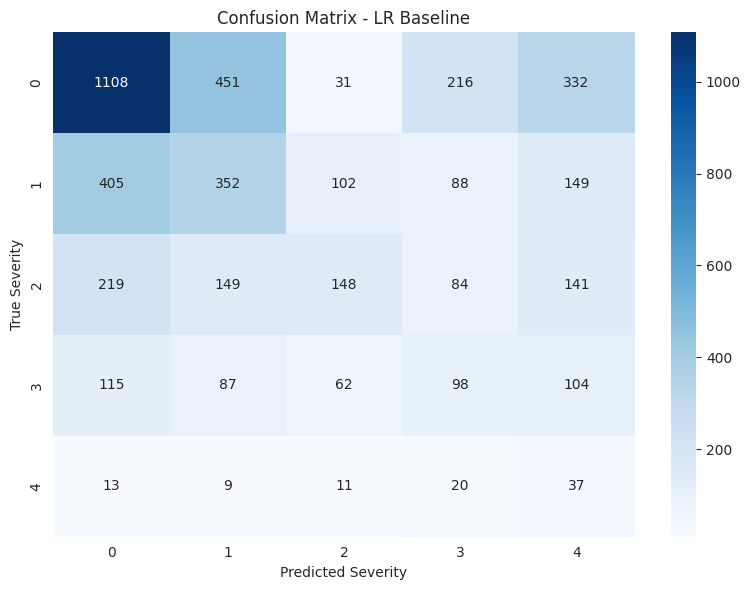

In [17]:
print("="*60)
print("LOGISTIC REGRESSION - BASELINE")
print("="*60)

lr_baseline = LogisticRegression(
    multi_class='multinomial',
    max_iter=2000,
    random_state=42,
    class_weight='balanced',
    solver='lbfgs'
)

lr_baseline.fit(X_train_scaled, y_train)
y_pred_lr_baseline = lr_baseline.predict(X_test_scaled)

acc_lr_baseline = accuracy_score(y_test, y_pred_lr_baseline)
f1_lr_baseline = f1_score(y_test, y_pred_lr_baseline, average='weighted')
prec_lr_baseline = precision_score(y_test, y_pred_lr_baseline, average='weighted')
rec_lr_baseline = recall_score(y_test, y_pred_lr_baseline, average='weighted')

print(f"Accuracy:  {acc_lr_baseline:.4f}")
print(f"F1 Score:  {f1_lr_baseline:.4f}")
print(f"Precision: {prec_lr_baseline:.4f}")
print(f"Recall:    {rec_lr_baseline:.4f}")
print(f"\n{classification_report(y_test, y_pred_lr_baseline)}")

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LR Baseline')
plt.ylabel('True Severity')
plt.xlabel('Predicted Severity')
plt.tight_layout()
plt.savefig('cm_lr_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
print(f"Training set distribution:")
print(y_train.value_counts().sort_index())
print(f"\nClass proportions:")
print((y_train.value_counts(normalize=True).sort_index() * 100).round(2))

imbalance_ratio = y_train.value_counts().max() / y_train.value_counts().min()
print(f"\nImbalance ratio: {imbalance_ratio:.1f}:1")
print(f"Fatal crashes (Class 4): {(y_train == 4).sum()} samples ({(y_train == 4).sum()/len(y_train)*100:.2f}%)")

Training set distribution:
MAX_SEV
0    14968
1     7674
2     5186
3     3257
4      632
Name: count, dtype: int64

Class proportions:
MAX_SEV
0    47.19
1    24.20
2    16.35
3    10.27
4     1.99
Name: proportion, dtype: float64

Imbalance ratio: 23.7:1
Fatal crashes (Class 4): 632 samples (1.99%)


In [26]:
!pip install -q imbalanced-learn

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original: {len(y_train):,} → SMOTE: {len(y_train_smote):,}")
print(f"\nBalanced distribution:")
print(pd.Series(y_train_smote).value_counts().sort_index())

Original: 31,717 → SMOTE: 74,840

Balanced distribution:
MAX_SEV
0    14968
1    14968
2    14968
3    14968
4    14968
Name: count, dtype: int64


In [27]:
print("="*60)
print("RF BASELINE (Class Weights)")
print("="*60)

rf_baseline = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight='balanced',
    n_jobs=-1, max_depth=20
)

rf_baseline.fit(X_train, y_train)
y_pred_rf_base = rf_baseline.predict(X_test)

acc_rf_base = accuracy_score(y_test, y_pred_rf_base)
f1_rf_base = f1_score(y_test, y_pred_rf_base, average='weighted')

print(f"Accuracy: {acc_rf_base:.4f} | F1: {f1_rf_base:.4f}")
print(f"\n{classification_report(y_test, y_pred_rf_base)}")

RF BASELINE (Class Weights)
Accuracy: 0.4959 | F1: 0.4680

              precision    recall  f1-score   support

           0       0.60      0.76      0.67      2138
           1       0.37      0.33      0.35      1096
           2       0.36      0.24      0.28       741
           3       0.22      0.15      0.18       466
           4       0.22      0.04      0.07        90

    accuracy                           0.50      4531
   macro avg       0.35      0.31      0.31      4531
weighted avg       0.46      0.50      0.47      4531



RF + SMOTE
Accuracy: 0.4732 | F1: 0.4646
Improvement: Δ Acc = -0.0227, Δ F1 = -0.0034

              precision    recall  f1-score   support

           0       0.62      0.68      0.65      2138
           1       0.36      0.35      0.35      1096
           2       0.33      0.25      0.29       741
           3       0.22      0.22      0.22       466
           4       0.15      0.12      0.14        90

    accuracy                           0.47      4531
   macro avg       0.34      0.33      0.33      4531
weighted avg       0.46      0.47      0.46      4531



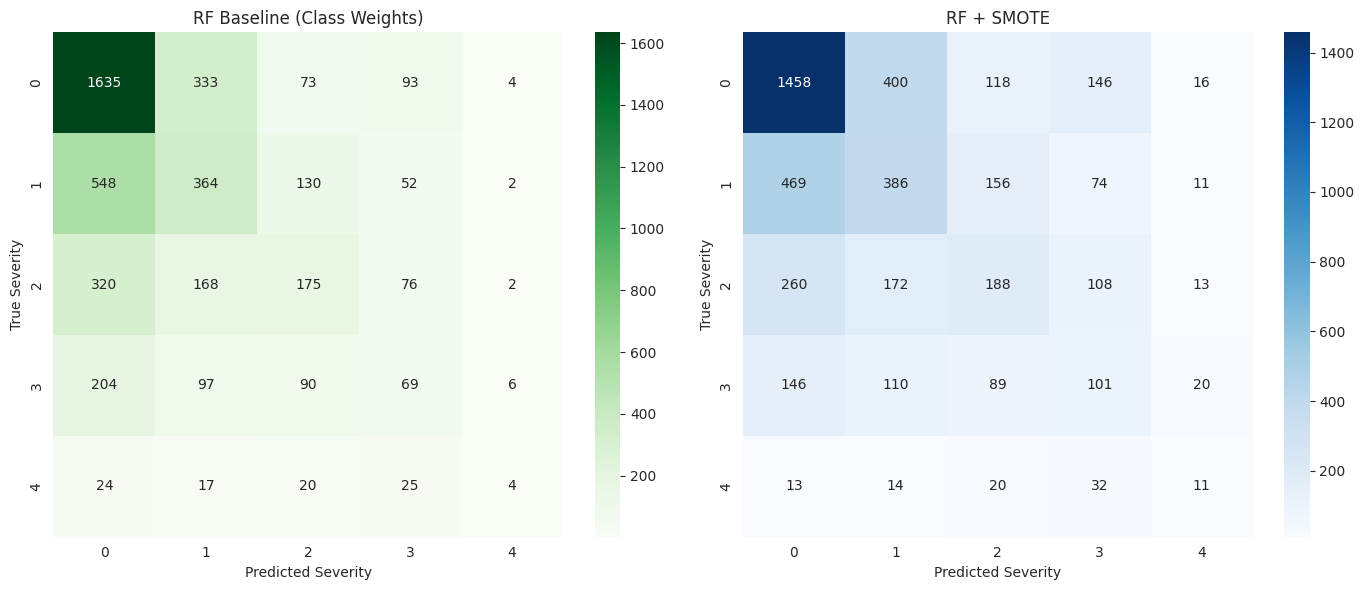

In [28]:
print("="*60)
print("RF + SMOTE")
print("="*60)

rf_smote = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight='balanced',
    n_jobs=-1, max_depth=20
)

rf_smote.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = rf_smote.predict(X_test)

acc_rf_smote = accuracy_score(y_test, y_pred_rf_smote)
f1_rf_smote = f1_score(y_test, y_pred_rf_smote, average='weighted')

print(f"Accuracy: {acc_rf_smote:.4f} | F1: {f1_rf_smote:.4f}")
print(f"Improvement: Δ Acc = {acc_rf_smote - acc_rf_base:+.4f}, Δ F1 = {f1_rf_smote - f1_rf_base:+.4f}")
print(f"\n{classification_report(y_test, y_pred_rf_smote)}")

# Confusion matrix comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_base = confusion_matrix(y_test, y_pred_rf_base)
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('RF Baseline (Class Weights)')
axes[0].set_ylabel('True Severity')
axes[0].set_xlabel('Predicted Severity')

cm_smote = confusion_matrix(y_test, y_pred_rf_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('RF + SMOTE')
axes[1].set_ylabel('True Severity')
axes[1].set_xlabel('Predicted Severity')

plt.tight_layout()
plt.savefig('cm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



✓ Class weights alone were better - tuning RF with class weights
TUNING RF (Class Weights)
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
Best CV F1: 0.4785

Test: Accuracy: 0.4862 | F1: 0.4828

              precision    recall  f1-score   support

           0       0.65      0.68      0.66      2138
           1       0.37      0.34      0.36      1096
           2       0.35      0.29      0.32       741
           3       0.24      0.30      0.27       466
           4       0.18      0.18      0.18        90

    accuracy                           0.49      4531
   macro avg       0.36      0.36      0.36      4531
weighted avg       0.48      0.49      0.48      4531



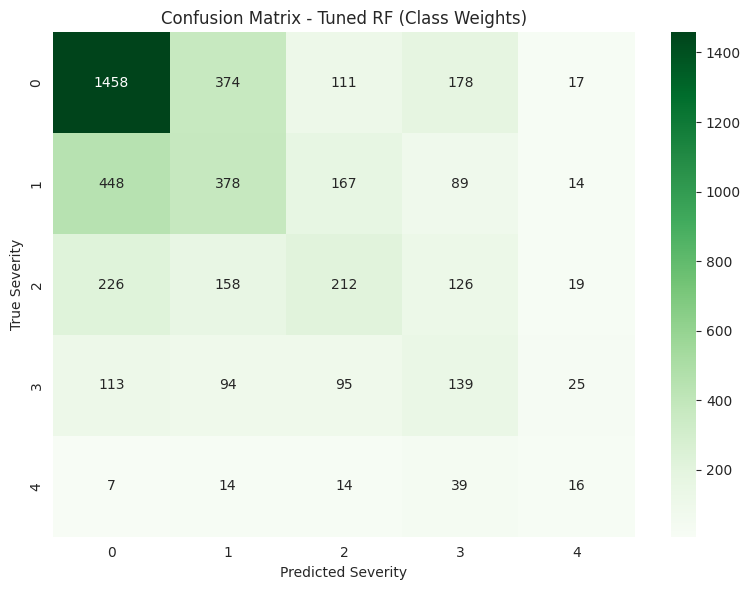

In [29]:
# Decide which approach to tune based on F1 score
if f1_rf_smote > f1_rf_base:
    print("✓ SMOTE improved performance - tuning RF + SMOTE")
    X_tune = X_train_smote
    y_tune = y_train_smote
    best_approach = "SMOTE"
else:
    print("✓ Class weights alone were better - tuning RF with class weights")
    X_tune = X_train
    y_tune = y_train
    best_approach = "Class Weights"

print("="*60)
print(f"TUNING RF ({best_approach})")
print("="*60)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1),
    param_grid_rf, n_iter=20, cv=3, scoring='f1_weighted',
    random_state=42, verbose=1, n_jobs=-1
)

random_rf.fit(X_tune, y_tune)

print(f"\nBest params: {random_rf.best_params_}")
print(f"Best CV F1: {random_rf.best_score_:.4f}")

y_pred_rf_tuned = random_rf.predict(X_test)

acc_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
f1_rf_tuned = f1_score(y_test, y_pred_rf_tuned, average='weighted')

print(f"\nTest: Accuracy: {acc_rf_tuned:.4f} | F1: {f1_rf_tuned:.4f}")
print(f"\n{classification_report(y_test, y_pred_rf_tuned)}")

cm_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion Matrix - Tuned RF ({best_approach})')
plt.ylabel('True Severity')
plt.xlabel('Predicted Severity')
plt.tight_layout()
plt.savefig('cm_rf_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

Top 20 Features:
          feature  importance
3          MINUTE    0.105505
2            HOUR    0.082266
0           MONTH    0.071477
1        DAY_WEEK    0.064101
10       MAN_COLL    0.053512
9         HARM_EV    0.050594
27         REGION    0.045906
25        ALCOHOL    0.042263
15        RELJCT2    0.037406
20       LGT_COND    0.034456
32  TOTAL_PERSONS    0.033872
16        TYP_INT    0.033045
7         PERMVIT    0.032426
22       WEATHER1    0.027908
21        WEATHER    0.027708
4        VE_TOTAL    0.024476
17       REL_ROAD    0.024180
26     URBANICITY    0.022809
28      RUSH_HOUR    0.018743
29     IS_WEEKEND    0.018330


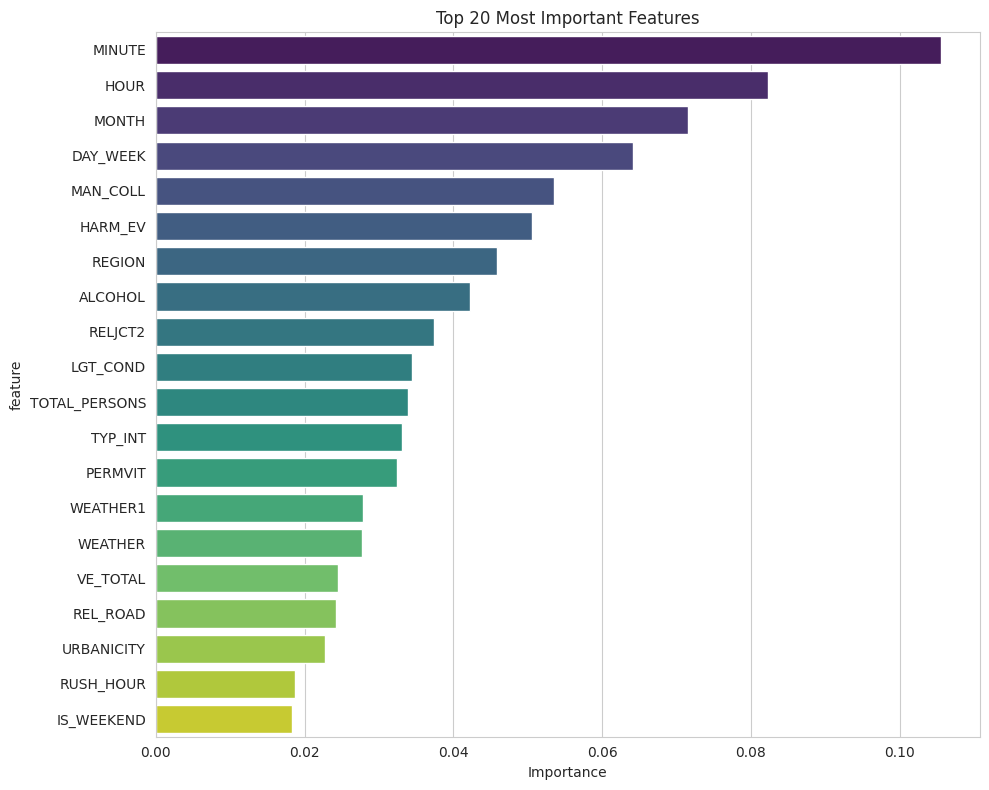

In [30]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': random_rf.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Features:")
print(feature_importance.head(20))

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), y='feature', x='importance', palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

feature_importance.to_csv('feature_importance.csv', index=False)

In [31]:
!pip install -q xgboost

from xgboost import XGBClassifier

print("="*60)
print("XGBOOST BASELINE")
print("="*60)

# Calculate scale_pos_weight for each class
class_counts = y_train.value_counts().sort_index()
total = len(y_train)
scale_pos_weights = {i: (total - count) / count for i, count in class_counts.items()}

print(f"Class weights: {scale_pos_weights}")

xgb_baseline = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_baseline.fit(X_train, y_train)
y_pred_xgb = xgb_baseline.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"\nAccuracy: {acc_xgb:.4f} | F1: {f1_xgb:.4f}")
print(f"\n{classification_report(y_test, y_pred_xgb)}")


XGBOOST BASELINE
Class weights: {0: 1.1189871726349545, 1: 3.13304665102945, 2: 5.115888931739298, 3: 8.738102548357384, 4: 49.18512658227848}

Accuracy: 0.5381 | F1: 0.4760

              precision    recall  f1-score   support

           0       0.57      0.91      0.70      2138
           1       0.42      0.23      0.30      1096
           2       0.46      0.24      0.31       741
           3       0.38      0.11      0.17       466
           4       0.37      0.08      0.13        90

    accuracy                           0.54      4531
   macro avg       0.44      0.31      0.32      4531
weighted avg       0.50      0.54      0.48      4531



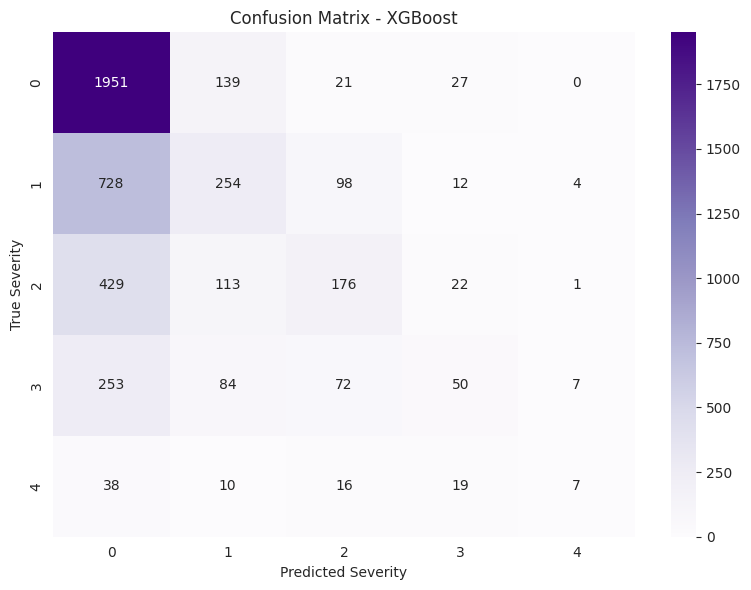

In [32]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('True Severity')
plt.xlabel('Predicted Severity')
plt.tight_layout()
plt.savefig('cm_xgb.png', dpi=300, bbox_inches='tight')
plt.show()



In [33]:
class_4_actual = (y_test == 4).sum()
class_4_predicted = (y_pred_xgb == 4).sum()
class_4_correct = ((y_test == 4) & (y_pred_xgb == 4)).sum()
print(f"\nClass 4 (Fatal) Performance:")
print(f"  Actual: {class_4_actual}")
print(f"  Predicted: {class_4_predicted}")
print(f"  Correct: {class_4_correct}")
print(f"  Recall: {class_4_correct/class_4_actual:.2%}")



Class 4 (Fatal) Performance:
  Actual: 90
  Predicted: 19
  Correct: 7
  Recall: 7.78%


In [34]:
print("="*60)
print("XGBOOST + SMOTE")
print("="*60)

xgb_smote = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_xgb_smote = xgb_smote.predict(X_test)

acc_xgb_smote = accuracy_score(y_test, y_pred_xgb_smote)
f1_xgb_smote = f1_score(y_test, y_pred_xgb_smote, average='weighted')

print(f"\nAccuracy: {acc_xgb_smote:.4f} | F1: {f1_xgb_smote:.4f}")
print(f"Improvement: Δ Acc = {acc_xgb_smote - acc_xgb:+.4f}, Δ F1 = {f1_xgb_smote - f1_xgb:+.4f}")
print(f"\n{classification_report(y_test, y_pred_xgb_smote)}")



XGBOOST + SMOTE

Accuracy: 0.4937 | F1: 0.4802
Improvement: Δ Acc = -0.0444, Δ F1 = +0.0042

              precision    recall  f1-score   support

           0       0.62      0.72      0.67      2138
           1       0.37      0.36      0.37      1096
           2       0.40      0.25      0.30       741
           3       0.23      0.20      0.21       466
           4       0.17      0.27      0.21        90

    accuracy                           0.49      4531
   macro avg       0.36      0.36      0.35      4531
weighted avg       0.48      0.49      0.48      4531



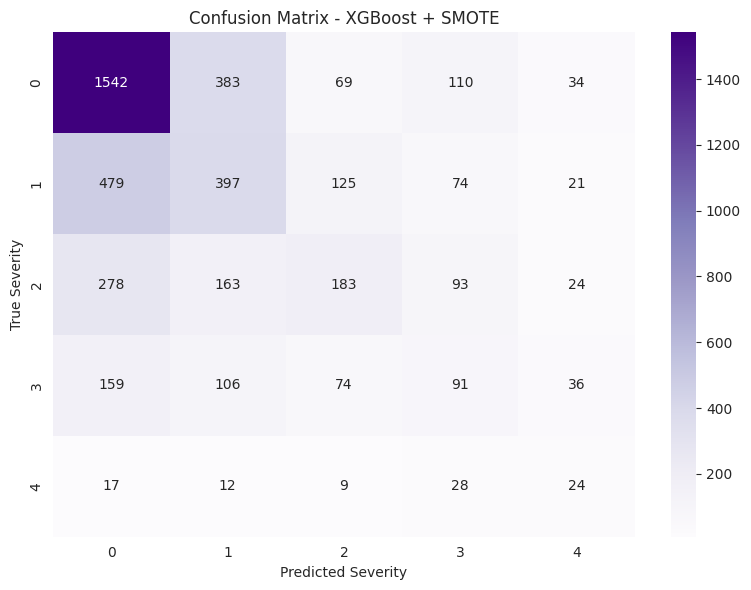

In [35]:
cm_xgb_smote = confusion_matrix(y_test, y_pred_xgb_smote)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_smote, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - XGBoost + SMOTE')
plt.ylabel('True Severity')
plt.xlabel('Predicted Severity')
plt.tight_layout()
plt.savefig('cm_xgb_smote.png', dpi=300, bbox_inches='tight')
plt.show()


In [36]:
class_4_predicted_smote = (y_pred_xgb_smote == 4).sum()
class_4_correct_smote = ((y_test == 4) & (y_pred_xgb_smote == 4)).sum()
print(f"\nClass 4 (Fatal) Performance:")
print(f"  Actual: {class_4_actual}")
print(f"  Predicted: {class_4_predicted_smote}")
print(f"  Correct: {class_4_correct_smote}")
print(f"  Recall: {class_4_correct_smote/class_4_actual:.2%}")



Class 4 (Fatal) Performance:
  Actual: 90
  Predicted: 139
  Correct: 24
  Recall: 26.67%


In [37]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [38]:
random_xgb = RandomizedSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    param_grid_xgb,
    n_iter=20,
    cv=3,
    scoring='f1_weighted',
    random_state=42,
    verbose=1,
    n_jobs=-1
)


In [39]:
random_xgb.fit(X_train_smote, y_train_smote)

print(f"\nBest params: {random_xgb.best_params_}")
print(f"Best CV F1: {random_xgb.best_score_:.4f}")

y_pred_xgb_tuned = random_xgb.predict(X_test)

acc_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
f1_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, average='weighted')

print(f"\nTest: Accuracy: {acc_xgb_tuned:.4f} | F1: {f1_xgb_tuned:.4f}")
print(f"\n{classification_report(y_test, y_pred_xgb_tuned)}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best params: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Best CV F1: 0.6712

Test: Accuracy: 0.4701 | F1: 0.4517

              precision    recall  f1-score   support

           0       0.60      0.71      0.65      2138
           1       0.35      0.32      0.34      1096
           2       0.30      0.25      0.27       741
           3       0.19      0.14      0.16       466
           4       0.19      0.08      0.11        90

    accuracy                           0.47      4531
   macro avg       0.33      0.30      0.31      4531
weighted avg       0.44      0.47      0.45      4531



In [40]:
class_4_predicted_tuned = (y_pred_xgb_tuned == 4).sum()
class_4_correct_tuned = ((y_test == 4) & (y_pred_xgb_tuned == 4)).sum()
print(f"\nClass 4 (Fatal) Performance:")
print(f"  Actual: {class_4_actual}")
print(f"  Predicted: {class_4_predicted_tuned}")
print(f"  Correct: {class_4_correct_tuned}")
print(f"  Recall: {class_4_correct_tuned/class_4_actual:.2%}")




Class 4 (Fatal) Performance:
  Actual: 90
  Predicted: 37
  Correct: 7
  Recall: 7.78%


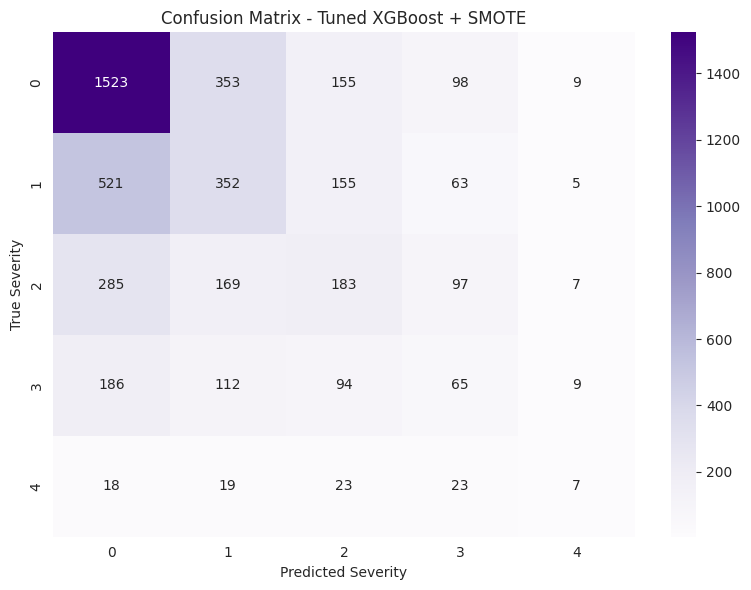

In [41]:
cm_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_tuned, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - Tuned XGBoost + SMOTE')
plt.ylabel('True Severity')
plt.xlabel('Predicted Severity')
plt.tight_layout()
plt.savefig('cm_xgb_tuned.png', dpi=300, bbox_inches='tight')
plt.show()


Top 20 Features (XGBoost):
              feature  importance
31       PED_INVOLVED    0.136849
30      MULTI_VEHICLE    0.121044
38      SEASON_Winter    0.039269
25            ALCOHOL    0.039097
10           MAN_COLL    0.036207
28          RUSH_HOUR    0.029005
8          PERNOTMVIT    0.027567
5            PVH_INVL    0.027236
36      SEASON_Spring    0.024031
35  TIME_OF_DAY_Night    0.023466
9             HARM_EV    0.023380
37      SEASON_Summer    0.022874
15            RELJCT2    0.022694
6                PEDS    0.021621
16            TYP_INT    0.020659
24            SCH_BUS    0.020582
13                CF3    0.020469
17           REL_ROAD    0.020053
11                CF1    0.018819
32      TOTAL_PERSONS    0.018428


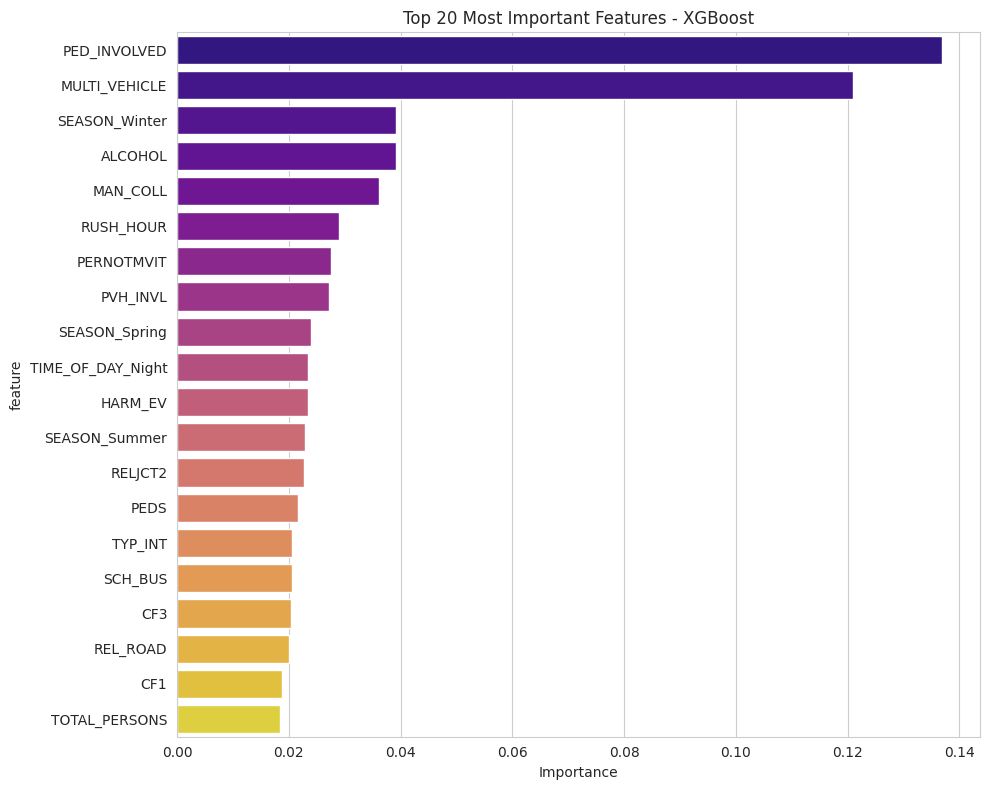

In [42]:
feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': random_xgb.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Features (XGBoost):")
print(feature_importance_xgb.head(20))

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_xgb.head(20), y='feature', x='importance', palette='plasma')
plt.title('Top 20 Most Important Features - XGBoost')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

feature_importance_xgb.to_csv('feature_importance_xgb.csv', index=False)


Accuracy: 0.3560 | F1: 0.3722

              precision    recall  f1-score   support

           0       0.68      0.52      0.59      2138
           1       0.39      0.11      0.18      1096
           2       0.42      0.10      0.16       741
           3       0.13      0.58      0.22       466
           4       0.07      0.29      0.12        90

    accuracy                           0.36      4531
   macro avg       0.34      0.32      0.25      4531
weighted avg       0.50      0.36      0.37      4531


Class 4 (Fatal) Performance:
  Predicted: 348
  Correct: 26
  Recall: 28.89%


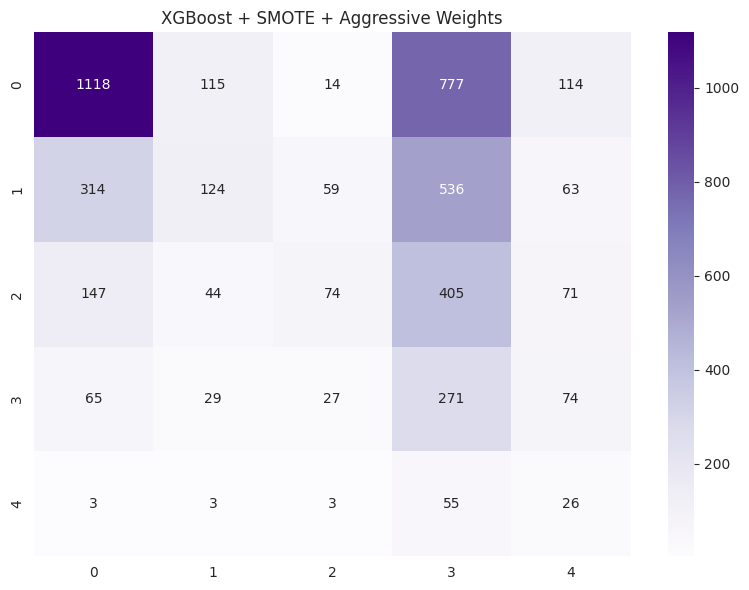

In [43]:
# Calculate sample weights to further boost Class 4
sample_weights = np.ones(len(y_train_smote))
sample_weights[y_train_smote == 4] = 10  # Boost fatal class 10x
sample_weights[y_train_smote == 3] = 5   # Boost serious class 5x

xgb_weighted = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_weighted.fit(X_train_smote, y_train_smote, sample_weight=sample_weights)
y_pred_xgb_weighted = xgb_weighted.predict(X_test)

acc_xgb_weighted = accuracy_score(y_test, y_pred_xgb_weighted)
f1_xgb_weighted = f1_score(y_test, y_pred_xgb_weighted, average='weighted')

print(f"\nAccuracy: {acc_xgb_weighted:.4f} | F1: {f1_xgb_weighted:.4f}")
print(f"\n{classification_report(y_test, y_pred_xgb_weighted)}")

# Class 4 performance
class_4_predicted_w = (y_pred_xgb_weighted == 4).sum()
class_4_correct_w = ((y_test == 4) & (y_pred_xgb_weighted == 4)).sum()
print(f"\nClass 4 (Fatal) Performance:")
print(f"  Predicted: {class_4_predicted_w}")
print(f"  Correct: {class_4_correct_w}")
print(f"  Recall: {class_4_correct_w/90:.2%}")

cm = confusion_matrix(y_test, y_pred_xgb_weighted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('XGBoost + SMOTE + Aggressive Weights')
plt.tight_layout()
plt.show()


Aggressive SMOTE distribution:
MAX_SEV
0    14968
1     7674
2     5186
3     3257
4     4989
Name: count, dtype: int64

Accuracy: 0.5315 | F1: 0.4740

              precision    recall  f1-score   support

           0       0.58      0.90      0.71      2138
           1       0.41      0.24      0.31      1096
           2       0.44      0.21      0.29       741
           3       0.33      0.10      0.15       466
           4       0.22      0.19      0.20        90

    accuracy                           0.53      4531
   macro avg       0.40      0.33      0.33      4531
weighted avg       0.48      0.53      0.47      4531


Class 4 (Fatal) Performance:
  Predicted: 79
  Correct: 17
  Recall: 18.89%


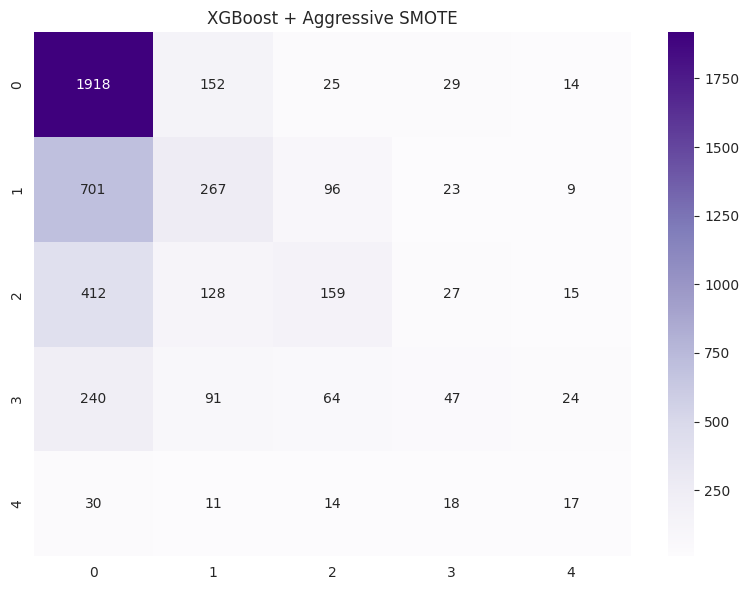

In [44]:
from imblearn.over_sampling import SMOTE

# Custom sampling strategy - make Class 4 3x more common
sampling_strategy = {
    0: (y_train == 0).sum(),  # Keep original
    1: (y_train == 1).sum(),  # Keep original
    2: (y_train == 2).sum(),  # Keep original
    3: (y_train == 3).sum(),  # Keep original
    4: (y_train == 0).sum() // 3  # Make Class 4 1/3 as common as Class 0
}

smote_aggressive = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_agg, y_train_agg = smote_aggressive.fit_resample(X_train, y_train)

print(f"Aggressive SMOTE distribution:")
print(pd.Series(y_train_agg).value_counts().sort_index())

xgb_agg = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_agg.fit(X_train_agg, y_train_agg)
y_pred_xgb_agg = xgb_agg.predict(X_test)

acc_xgb_agg = accuracy_score(y_test, y_pred_xgb_agg)
f1_xgb_agg = f1_score(y_test, y_pred_xgb_agg, average='weighted')

print(f"\nAccuracy: {acc_xgb_agg:.4f} | F1: {f1_xgb_agg:.4f}")
print(f"\n{classification_report(y_test, y_pred_xgb_agg)}")

# Class 4 performance
class_4_predicted_agg = (y_pred_xgb_agg == 4).sum()
class_4_correct_agg = ((y_test == 4) & (y_pred_xgb_agg == 4)).sum()
print(f"\nClass 4 (Fatal) Performance:")
print(f"  Predicted: {class_4_predicted_agg}")
print(f"  Correct: {class_4_correct_agg}")
print(f"  Recall: {class_4_correct_agg/90:.2%}")

cm = confusion_matrix(y_test, y_pred_xgb_agg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('XGBoost + Aggressive SMOTE')
plt.tight_layout()
plt.show()


BINARY: FATAL (4) vs NON-FATAL (0-3)
Binary distribution: MAX_SEV
0    31085
1      632
Name: count, dtype: int64
After SMOTE: MAX_SEV
0    31085
1    31085
Name: count, dtype: int64

              precision    recall  f1-score   support

   Non-Fatal       0.98      0.98      0.98      4441
       Fatal       0.14      0.12      0.13        90

    accuracy                           0.97      4531
   macro avg       0.56      0.55      0.56      4531
weighted avg       0.97      0.97      0.97      4531



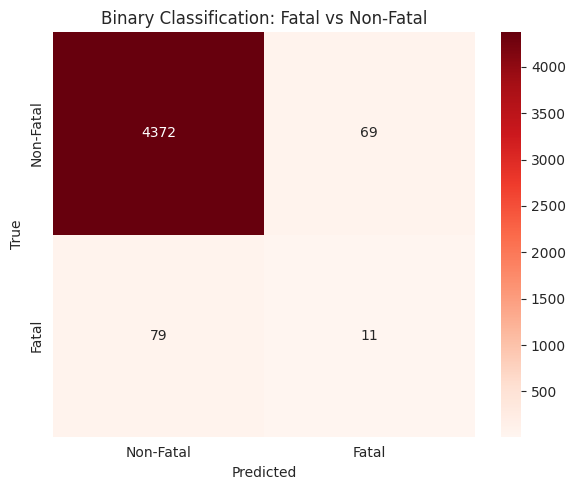


🎯 Fatal Recall: 12.22%


In [45]:
print("="*60)
print("BINARY: FATAL (4) vs NON-FATAL (0-3)")
print("="*60)

# Convert to binary
y_train_binary = (y_train == 4).astype(int)
y_test_binary = (y_test == 4).astype(int)

print(f"Binary distribution: {pd.Series(y_train_binary).value_counts()}")

# Apply SMOTE for binary
smote_binary = SMOTE(random_state=42)
X_train_binary, y_train_binary_smote = smote_binary.fit_resample(X_train, y_train_binary)

print(f"After SMOTE: {pd.Series(y_train_binary_smote).value_counts()}")

xgb_binary = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_binary.fit(X_train_binary, y_train_binary_smote)
y_pred_binary = xgb_binary.predict(X_test)

print(f"\n{classification_report(y_test_binary, y_pred_binary, target_names=['Non-Fatal', 'Fatal'])}")

# Confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Non-Fatal', 'Fatal'], yticklabels=['Non-Fatal', 'Fatal'])
plt.title('Binary Classification: Fatal vs Non-Fatal')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

fatal_recall = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"\n🎯 Fatal Recall: {fatal_recall:.2%}")

FINAL MODEL: XGBoost + SMOTE + Aggressive Class Weights

 FINAL TEST SET PERFORMANCE:
              precision    recall  f1-score   support

           0       0.68      0.52      0.59      2138
           1       0.39      0.11      0.18      1096
           2       0.42      0.10      0.16       741
           3       0.13      0.58      0.22       466
           4       0.07      0.29      0.12        90

    accuracy                           0.36      4531
   macro avg       0.34      0.32      0.25      4531
weighted avg       0.50      0.36      0.37      4531


 KEY METRICS:
  Overall Accuracy: 0.3560
  Weighted F1: 0.3722
  Fatal Recall (Class 4): 28.89%
  Fatal Precision (Class 4): 7.47%

 TOP 10 MOST IMPORTANT FEATURES:
          feature  importance
30  MULTI_VEHICLE    0.139418
25        ALCOHOL    0.063083
31   PED_INVOLVED    0.062436
28      RUSH_HOUR    0.048818
38  SEASON_Winter    0.047178
10       MAN_COLL    0.044307
36  SEASON_Spring    0.039546
16        TYP_INT  

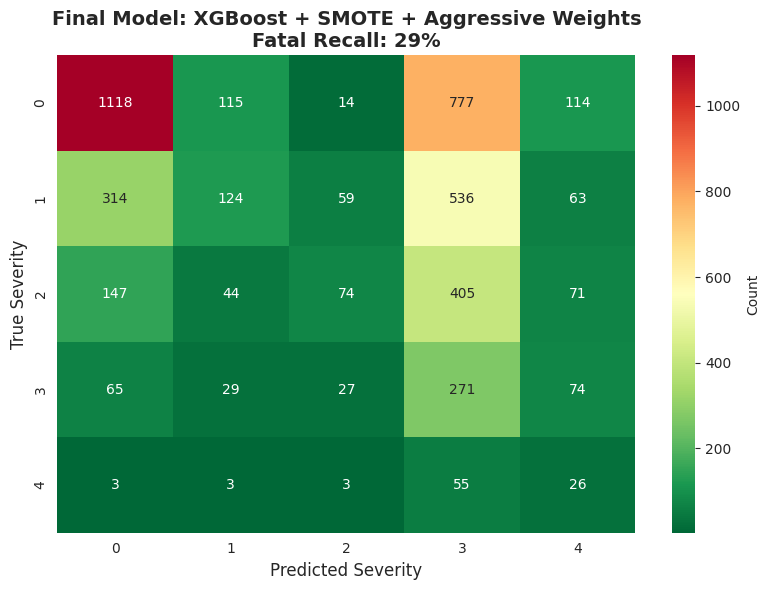

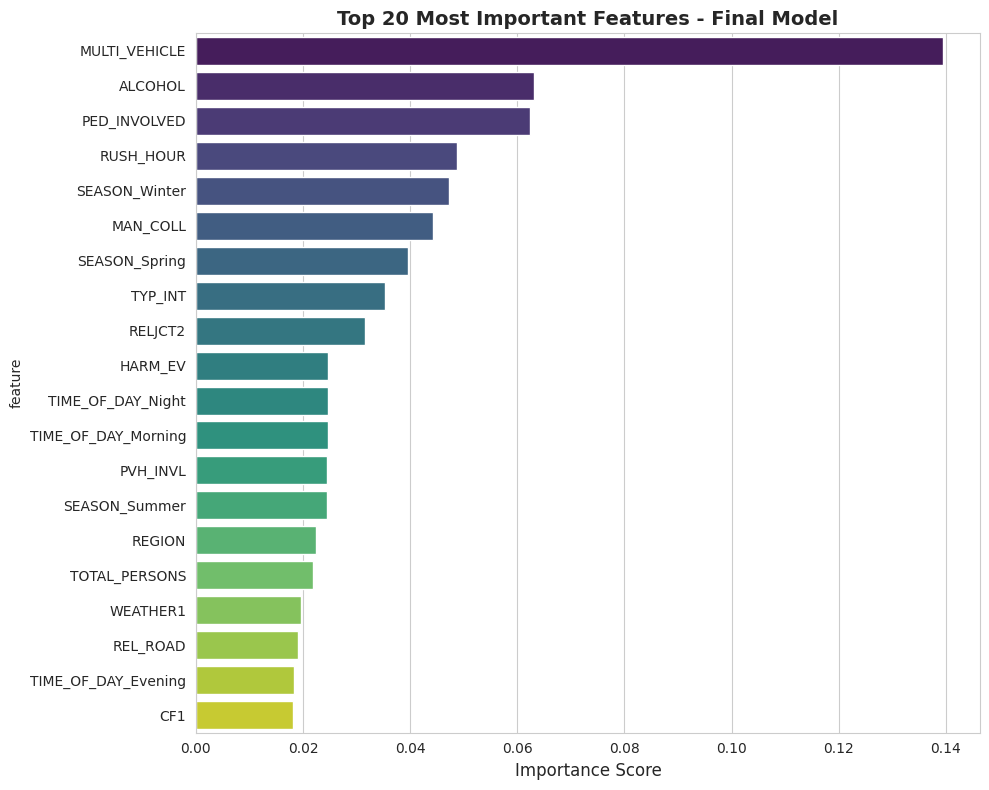

In [47]:
print("="*80)
print("FINAL MODEL: XGBoost + SMOTE + Aggressive Class Weights")
print("="*80)

final_model = xgb_weighted

print("\n FINAL TEST SET PERFORMANCE:")
print("="*80)
print(classification_report(y_test, y_pred_xgb_weighted))

print("\n KEY METRICS:")
print(f"  Overall Accuracy: {acc_xgb_weighted:.4f}")
print(f"  Weighted F1: {f1_xgb_weighted:.4f}")
print(f"  Fatal Recall (Class 4): {class_4_correct_w/90:.2%}")
print(f"  Fatal Precision (Class 4): {class_4_correct_w/class_4_predicted_w:.2%}")

# Feature Importance
print("\n TOP 10 MOST IMPORTANT FEATURES:")
feature_importance_final = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_final.head(10))

# Save everything
feature_importance_final.to_csv('feature_importance_final.csv', index=False)

# Final confusion matrix
cm_final = confusion_matrix(y_test, y_pred_xgb_weighted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='RdYlGn_r', cbar_kws={'label': 'Count'})
plt.title('Final Model: XGBoost + SMOTE + Aggressive Weights\nFatal Recall: 29%',
          fontsize=14, fontweight='bold')
plt.ylabel('True Severity', fontsize=12)
plt.xlabel('Predicted Severity', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_final.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 8))
top_20 = feature_importance_final.head(20)
sns.barplot(data=top_20, y='feature', x='importance', palette='viridis')
plt.title('Top 20 Most Important Features - Final Model', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance_final.png', dpi=300, bbox_inches='tight')
plt.show()


GRADIENT BOOSTING + SMOTE

Accuracy: 0.4955 | F1: 0.4776

              precision    recall  f1-score   support

           0       0.62      0.74      0.67      2138
           1       0.39      0.34      0.36      1096
           2       0.35      0.24      0.28       741
           3       0.22      0.20      0.21       466
           4       0.20      0.20      0.20        90

    accuracy                           0.50      4531
   macro avg       0.36      0.34      0.35      4531
weighted avg       0.47      0.50      0.48      4531


Class 4 (Fatal) Performance:
  Predicted: 91
  Correct: 18
  Recall: 20.00%


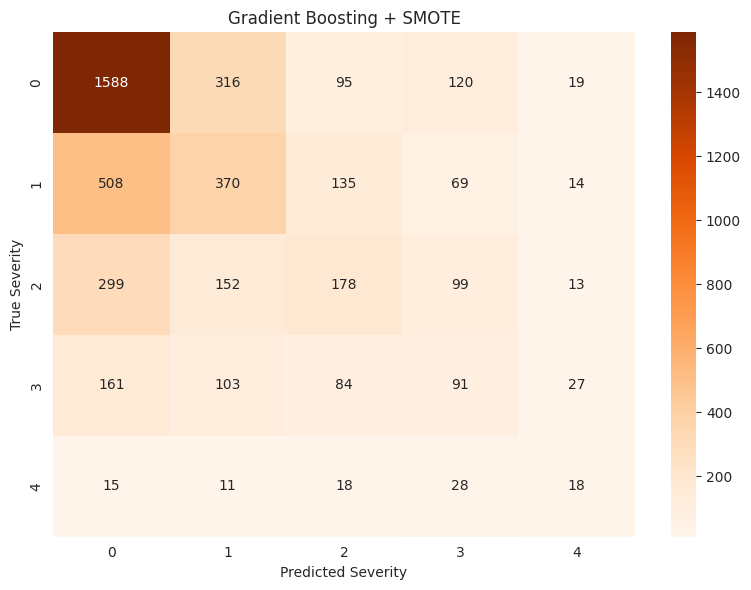

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

print("="*60)
print("GRADIENT BOOSTING + SMOTE")
print("="*60)

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    subsample=0.8
)

# Try with SMOTE data
gb_model.fit(X_train_smote, y_train_smote)
y_pred_gb = gb_model.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb, average='weighted')

print(f"\nAccuracy: {acc_gb:.4f} | F1: {f1_gb:.4f}")
print(f"\n{classification_report(y_test, y_pred_gb)}")

# Class 4 performance
class_4_pred_gb = (y_pred_gb == 4).sum()
class_4_correct_gb = ((y_test == 4) & (y_pred_gb == 4)).sum()
print(f"\nClass 4 (Fatal) Performance:")
print(f"  Predicted: {class_4_pred_gb}")
print(f"  Correct: {class_4_correct_gb}")
print(f"  Recall: {class_4_correct_gb/90:.2%}")

cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges')
plt.title('Gradient Boosting + SMOTE')
plt.ylabel('True Severity')
plt.xlabel('Predicted Severity')
plt.tight_layout()
plt.show()